In [ ]:
# 📓 traditional_backend_sid/face_detection_live.ipynb

import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import joblib

# === Step 1: Prepare Dataset from ./dataset/person_name/*.jpg ===
face_size = (100, 100)
faces = []
labels = []
dataset_dir = "../dataset"

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

for person_name in os.listdir(dataset_dir):
    person_folder = os.path.join(dataset_dir, person_name)
    if not os.path.isdir(person_folder):
        continue

    for img_name in os.listdir(person_folder):
        img_path = os.path.join(person_folder, img_name)

        image = cv2.imread(img_path)
        if image is None:
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)

        faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        for (x, y, w, h) in faces_rect:
            face_roi = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_roi, face_size)
            faces.append(face_resized.flatten())
            labels.append(person_name)

# === Step 2: Encode Labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# === Step 3: PCA (Eigenfaces) + Classifier (KNN) ===
pca = PCA(n_components=100, whiten=True, random_state=42)
x_pca = pca.fit_transform(faces)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_pca, y_encoded)

# Save the model for later (optional)
joblib.dump(pca, "pca_model.pkl")
joblib.dump(knn, "knn_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("[INFO] Model trained and saved. Ready for live demo.")

# === Live Detection & Recognition Loop ===
cap = cv2.VideoCapture(0)

print("[INFO] Press 'q' to exit the live feed...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    faces_live = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces_live:
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, face_size).flatten().reshape(1, -1)
        face_pca = pca.transform(face_resized)
        prediction = knn.predict(face_pca)
        name = le.inverse_transform(prediction)[0]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow("Live Face Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("[INFO] Exiting live stream...")
        break

cap.release()
cv2.destroyAllWindows()



# Attempt 1

[INFO] Processing class: amisha
[INFO] Processing class: dhanoosh
[INFO] Processing class: jose
[INFO] Processing class: jui
[INFO] Processing class: ritvi
[INFO] Processing class: siddhangana
[INFO] Processing class: sparsh
[INFO] Processing class: yash
[INFO] Total faces detected: 12


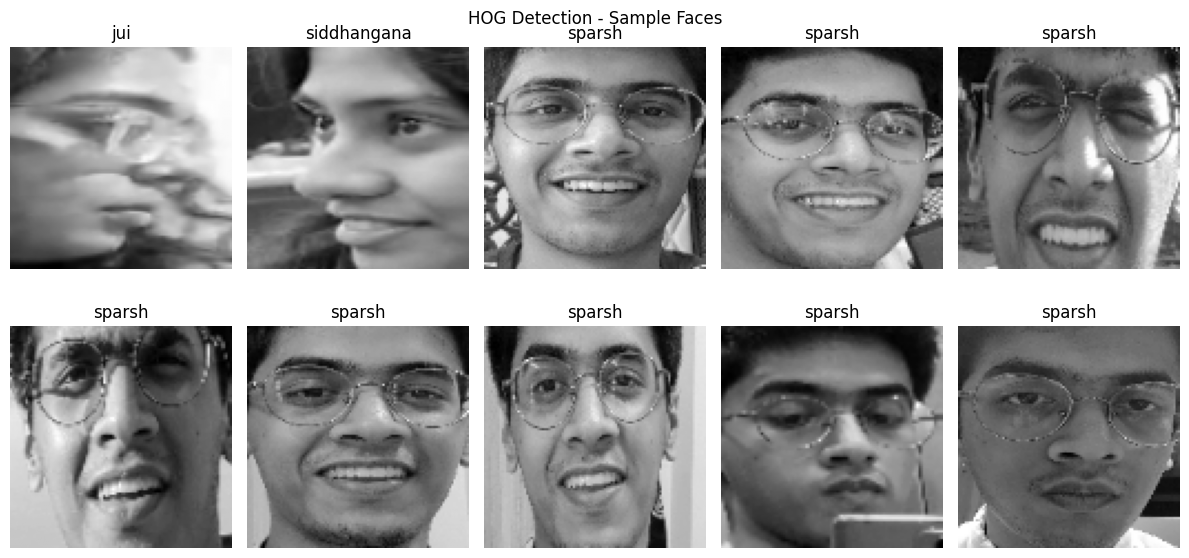

In [1]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

DATASET_DIR = "../dataset"
FACE_SIZE = (100, 100)
hog_detector = dlib.get_frontal_face_detector()

faces = []
labels = []

MAX_IMAGES_PER_CLASS = 10
RESIZE_BEFORE_DETECT = (400, 400)

for person in os.listdir(DATASET_DIR):
    person_path = os.path.join(DATASET_DIR, person)
    if not os.path.isdir(person_path):
        continue

    count = 0
    print(f"[INFO] Processing class: {person}")

    for img_name in os.listdir(person_path):
        if count >= MAX_IMAGES_PER_CLASS:
            break

        img_path = os.path.join(person_path, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.resize(image, RESIZE_BEFORE_DETECT)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        detected = hog_detector(gray, 0)  # 0 = no upsampling (faster)

        for d in detected:
            x, y, w, h = d.left(), d.top(), d.width(), d.height()
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, FACE_SIZE)
            faces.append(face)
            labels.append(person)
            count += 1
            break  # Only one face per image

print(f"[INFO] Total faces detected: {len(faces)}")

plt.figure(figsize=(12, 6))
for i in range(min(10, len(faces))):
    plt.subplot(2, 5, i+1)
    plt.imshow(faces[i].reshape(FACE_SIZE), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.suptitle("HOG Detection - Sample Faces")
plt.show()


In [ ]:
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import Isomap
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import joblib
from skimage.feature import local_binary_pattern

radius = 1
n_points = 8 * radius
method = 'uniform'

def extract_lbp_features(image):
    lbp = local_binary_pattern(image, n_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# === Encode Labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# === Extract LBP Features from Faces ===
X = np.array([extract_lbp_features(face) for face in faces])
y = np.array(y_encoded)

# === Train/Test Split (with class check) ===
unique, counts = np.unique(y, return_counts=True)
min_class_count = np.min(counts)

if min_class_count < 2 or len(y) < 5:
    print("[WARN] Some classes have <2 samples. Skipping stratified split.")
    X_train, X_test = X, X
    y_train, y_test = y, y
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

# === Isomap Dimensionality Reduction ===
isomap = Isomap(n_components=min(15, X_train.shape[1]))
X_train_iso = isomap.fit_transform(X_train)

# === Train Classifier ===
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_iso, y_train)

# Save models
joblib.dump(isomap, "isomap_model.pkl")
joblib.dump(svm, "svm_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ Model pipeline trained: LBP + Isomap + SVM")


In [ ]:
import cv2
import numpy as np
import joblib
from skimage.feature import local_binary_pattern

# === Load trained models ===
isomap = joblib.load("isomap_model.pkl")
svm = joblib.load("svm_model.pkl")
le = joblib.load("label_encoder.pkl")

# === Parameters ===
FACE_SIZE = (100, 100)
radius = 1
n_points = 8 * radius
method = 'uniform'

# === Load Haar Cascade for Detection ===
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# === LBP Feature Extractor ===
def extract_lbp_features(image):
    lbp = local_binary_pattern(image, n_points, radius, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize histogram
    return hist

# === Start Webcam ===
cap = cv2.VideoCapture(0)
print("[INFO] Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("[ERROR] Failed to grab frame.")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces_rect:
        face_roi = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face_roi, FACE_SIZE)

        lbp_feat = extract_lbp_features(face_resized).reshape(1, -1)
        feat_proj = isomap.transform(lbp_feat)
        probs = svm.predict_proba(feat_proj)[0]
        pred = np.argmax(probs)
        confidence = probs[pred]

        if confidence >= 0.5:
            name = le.inverse_transform([pred])[0]
        else:
            name = "Unknown"

        # Draw bounding box and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        label_text = f"{name} ({confidence:.2f})"
        cv2.putText(frame, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    cv2.imshow("Live Face Recognition (LBP+Isomap+SVM)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("[INFO] Exiting...")
        break

cap.release()
cv2.destroyAllWindows()

[INFO] Scanning dataset and applying Viola-Jones detection...

[INFO] Number of faces detected per class:
amisha: 1 faces
dhanoosh: 12 faces
jose: 9 faces
jui: 9 faces
ritvi: 13 faces
siddhangana: 19 faces
sparsh: 24 faces
yash: 19 faces

[⚠️ WARNING] Some classes have <2 detected faces. Stratified split will not be used.
⚠️ Class 'amisha' has only 1 sample(s).

[INFO] Visualizing Detected Training Faces using Viola-Jones:


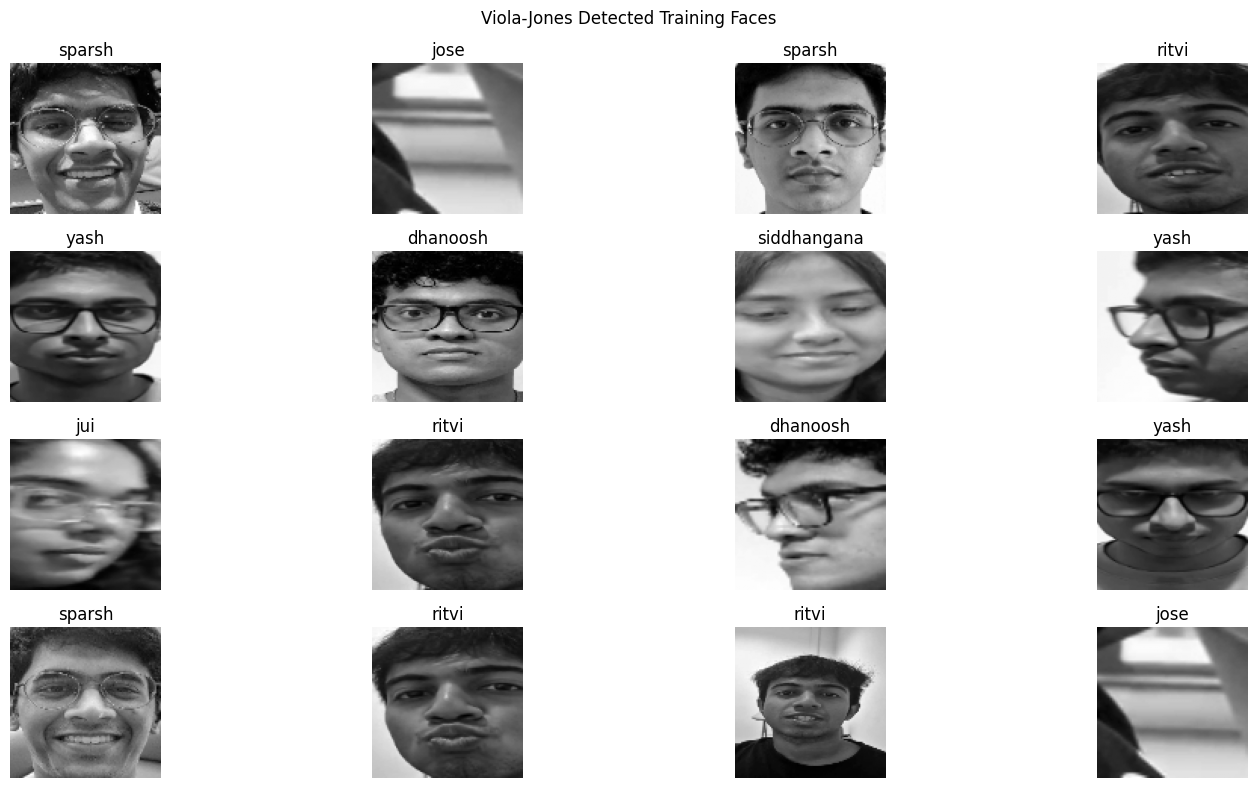

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

# === Configuration ===
DATASET_DIR = "../dataset"
FACE_SIZE = (100, 100)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# === Data Storage ===
faces = []
labels = []
class_counts = defaultdict(int)

print("[INFO] Scanning dataset and applying Viola-Jones detection...")

# === Detection Loop ===
for person in os.listdir(DATASET_DIR):
    person_path = os.path.join(DATASET_DIR, person)
    if not os.path.isdir(person_path):
        continue

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.resize(image, (400, 400))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Viola-Jones face detection
        detections = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        for (x, y, w, h) in detections:
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, FACE_SIZE)
            faces.append(face)
            labels.append(person)
            class_counts[person] += 1
            break  # Only one face per image

# === Display Class-wise Counts ===
print("\n[INFO] Number of faces detected per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} faces")

# === Convert to NumPy Arrays ===
faces = np.array(faces)
labels = np.array(labels)

# === Robust Split: Handle <2 samples with fallback ===
label_counter = Counter(labels)
min_class_count = min(label_counter.values())

if min_class_count < 2:
    print("\n[⚠️ WARNING] Some classes have <2 detected faces. Stratified split will not be used.")
    for cls, count in label_counter.items():
        if count < 2:
            print(f"⚠️ Class '{cls}' has only {count} sample(s).")

    X_train, X_test, y_train, y_test = train_test_split(
        faces, labels, test_size=0.25, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        faces, labels, test_size=0.25, stratify=labels, random_state=42
    )

# === Visualization ===
def plot_faces(images, labels, title, max_images=16):
    plt.figure(figsize=(16, 8))
    for i in range(min(len(images), max_images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("\n[INFO] Visualizing Detected Training Faces using Viola-Jones:")
plot_faces(X_train, y_train, "Viola-Jones Detected Training Faces")


[INFO] Using 79 principal components (Eigenfaces)
[INFO] Classification Report:
              precision    recall  f1-score   support

      amisha       0.00      0.00      0.00         1
    dhanoosh       0.00      0.00      0.00         4
        jose       0.00      0.00      0.00         1
         jui       0.00      0.00      0.00         3
       ritvi       0.00      0.00      0.00         3
 siddhangana       0.00      0.00      0.00         5
      sparsh       0.26      1.00      0.41         7
        yash       0.00      0.00      0.00         3

    accuracy                           0.26        27
   macro avg       0.03      0.12      0.05        27
weighted avg       0.07      0.26      0.11        27



c:\Users\siddh\anaconda3\envs\face_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\siddh\anaconda3\envs\face_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\siddh\anaconda3\envs\face_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

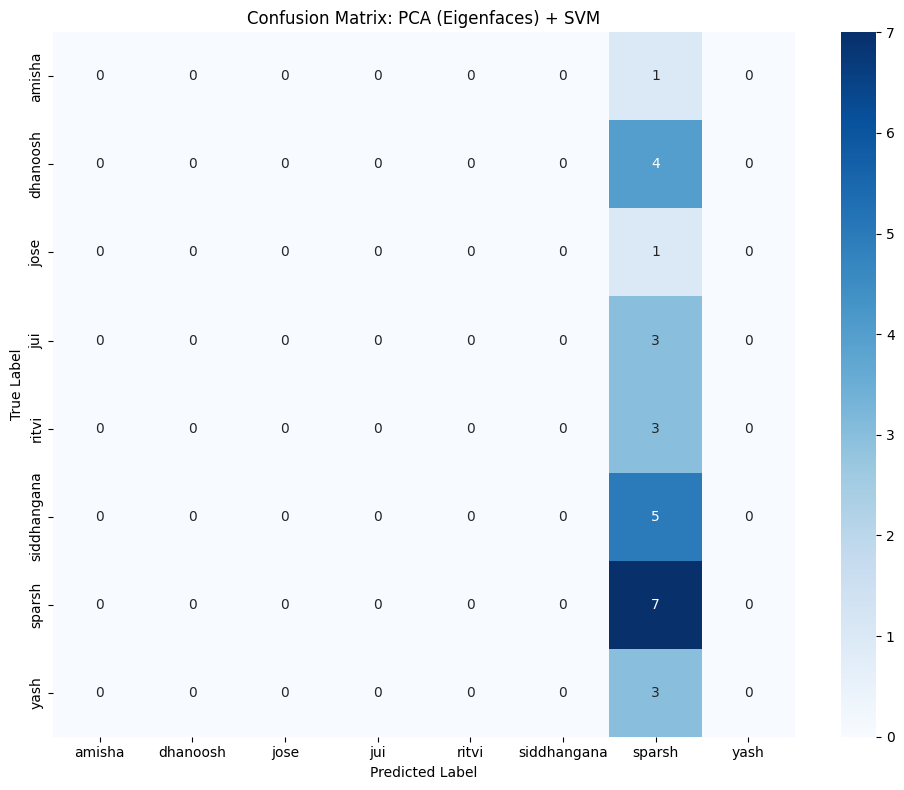

✅ Accuracy: 25.93%


['eigenfaces_svm.pkl']

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# === Preprocessing ===
X_train_flat = X_train.reshape(len(X_train), -1).astype(np.float32)
X_test_flat = X_test.reshape(len(X_test), -1).astype(np.float32)

# === Adaptive Component Setting ===
max_components = min(len(X_train_flat), X_train_flat.shape[1], 100)
print(f"[INFO] Using {max_components} principal components (Eigenfaces)")

# === PCA ===
pca = PCA(n_components=max_components, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# === Train Classifier ===
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_pca, y_train)

# === Prediction and Evaluation ===
y_pred = svm.predict(X_test_pca)

print("[INFO] Classification Report:")
print(classification_report(y_test, y_pred))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: PCA (Eigenfaces) + SVM")
plt.tight_layout()
plt.show()

# === Accuracy ===
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc * 100:.2f}%")

# === Save Models ===
joblib.dump(pca, "eigenfaces_pca.pkl")
joblib.dump(svm, "eigenfaces_svm.pkl")


[INFO] Scanning dataset using HOG-based detection...

[INFO] Number of faces detected per class:
jui: 1 faces
siddhangana: 1 faces
sparsh: 22 faces

[⚠️ WARNING] Some classes have <2 detected faces. Stratified split will not be used.
⚠️ Class 'jui' has only 1 sample(s).
⚠️ Class 'siddhangana' has only 1 sample(s).

[INFO] Visualizing HOG-Detected Training Faces:


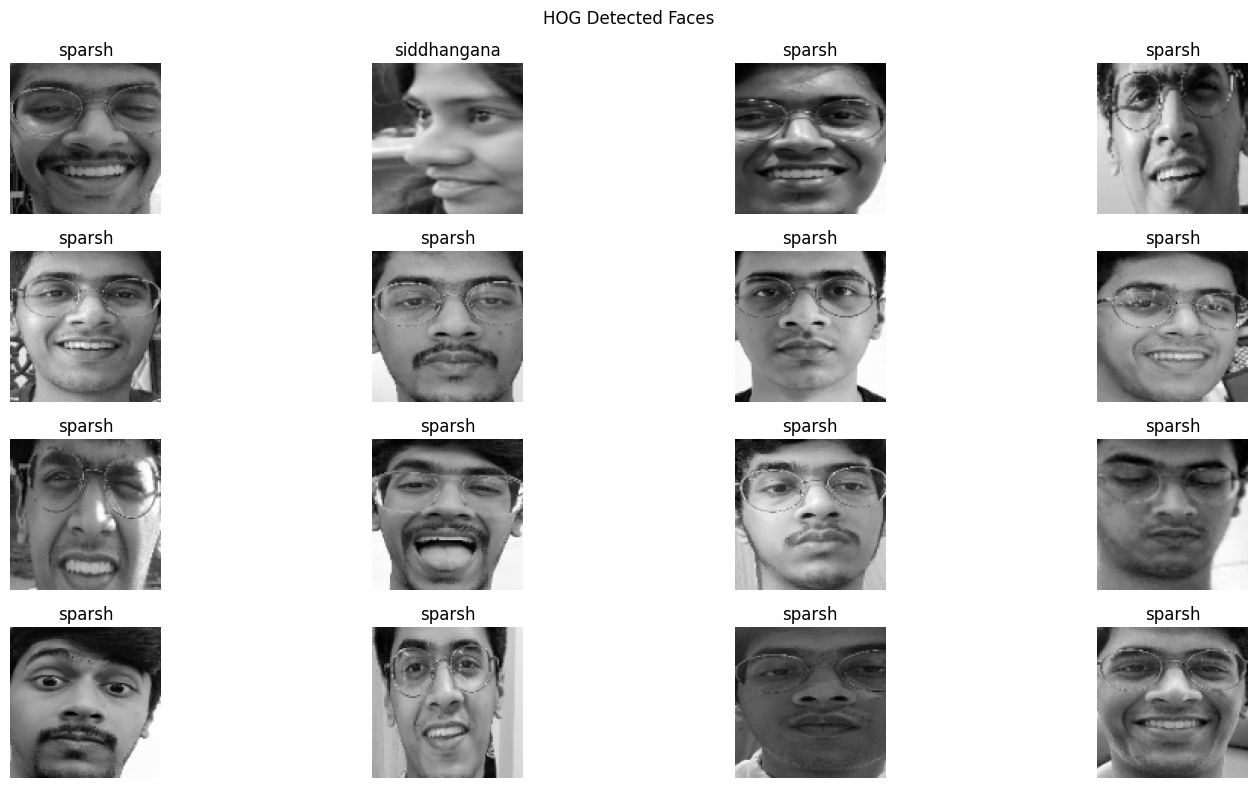

In [5]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

# === Configuration ===
DATASET_DIR = "../dataset"
FACE_SIZE = (100, 100)
hog_detector = dlib.get_frontal_face_detector()

# === Data Storage ===
hog_faces = []
hog_labels = []
class_counts = defaultdict(int)

print("[INFO] Scanning dataset using HOG-based detection...")

# === Detection Loop ===
for person in os.listdir(DATASET_DIR):
    person_path = os.path.join(DATASET_DIR, person)
    if not os.path.isdir(person_path):
        continue

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.resize(image, (400, 400))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        detections = hog_detector(gray, 0)  # 0 = no upsampling

        for d in detections:
            x, y, w, h = d.left(), d.top(), d.width(), d.height()
            if x >= 0 and y >= 0:
                face = gray[y:y+h, x:x+w]
                face = cv2.resize(face, FACE_SIZE)
                hog_faces.append(face)
                hog_labels.append(person)
                class_counts[person] += 1
                break  # Only one face per image

# === Display Class-wise Counts ===
print("\n[INFO] Number of faces detected per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} faces")

# === Convert to NumPy Arrays ===
hog_faces = np.array(hog_faces)
hog_labels = np.array(hog_labels)

# === Robust Train-Test Split ===
label_counter = Counter(hog_labels)
min_class_count = min(label_counter.values())

if min_class_count < 2:
    print("\n[⚠️ WARNING] Some classes have <2 detected faces. Stratified split will not be used.")
    for cls, count in label_counter.items():
        if count < 2:
            print(f"⚠️ Class '{cls}' has only {count} sample(s).")

    X_train, X_test, y_train, y_test = train_test_split(
        hog_faces, hog_labels, test_size=0.25, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        hog_faces, hog_labels, test_size=0.25, stratify=hog_labels, random_state=42
    )

# === Visualization ===
def plot_faces(images, labels, title, max_images=16):
    plt.figure(figsize=(16, 8))
    for i in range(min(len(images), max_images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("\n[INFO] Visualizing HOG-Detected Training Faces:")
plot_faces(X_train, y_train, "HOG Detected Faces")
